# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# tqdm Instantly make your loops show a smart progress meter 
from tqdm import tqdm
import os

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect("D:\\AAIC\\datasetes\\amazon-fine-food-reviews\\database.sqlite") 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negetive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)






Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
print(sorted_data)

            Id   ProductId          UserId  \
138706  150524  0006641040   ACITT7DI6IDDL   
138688  150506  0006641040  A2IW4PEEKO2R0U   
138689  150507  0006641040  A1S4A3IQ2MU7V4   
138690  150508  0006641040     AZGXZ2UUK6X   
138691  150509  0006641040  A3CMRKGE0P909G   
138693  150511  0006641040  A1C9K534BCI9GO   
138694  150512  0006641040  A1DJXZA5V5FFVA   
138695  150513  0006641040   ASH0DZQQF6AIZ   
138696  150514  0006641040   A2ONB6ZA292PA   
138697  150515  0006641040  A2RTT81R6Y3R7X   
138687  150505  0006641040  A2PTSM496CF40Z   
138698  150516  0006641040  A3OI7ZGH6WZJ5G   
138700  150518  0006641040   AK1L4EJBA23JF   
138701  150519  0006641040  A12HY5OZ2QNK4N   
138702  150520  0006641040   ADBFSA9KTQANE   
138703  150521  0006641040  A3RMCRB2NDTDYP   
138704  150522  0006641040  A1S3C5OFU508P3   
138705  150523  0006641040  A2P4F2UO0UMP8C   
138707  150525  0006641040  A2QID6VCFTY51R   
138708  150526  0006641040  A3E9QZFE9KXH8J   
138709  150529  0006641040   A25AC

[525814 rows x 10 columns]


In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size)/(filtered_data['Id'].size)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [7]:
#keeping only the data which has helpfullness denominator greater than helpfulness numerator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
     if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
     i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [10]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'you', 'where', 'about', 'hers', "that'll", 'couldn', 'but', 'did', 'and', 't', 'd', 'been', 'some', 'no', 'because', 'ma', 'down', 'into', 'when', 'himself', "doesn't", 'if', 'again', 'on', 'these', 'me', "didn't", 'am', 'are', 'there', 'until', 'what', 'same', 'will', 'does', 'our', 'before', "won't", 'myself', 'isn', 'that', 'after', 'its', 'll', 'all', 'too', 'between', "shan't", 'off', 'most', 'below', 'them', 'of', 'it', 'my', 'won', "mightn't", "you'll", 'has', 'so', 'out', "shouldn't", 'this', 'an', 'o', 'under', 'your', 'doesn', 'each', "wouldn't", "it's", 'nor', 'only', 'by', 'other', 'few', 'own', "isn't", 'having', 'i', 'just', 'then', 'which', 'she', 'more', "hadn't", 'as', 'theirs', 'over', 'up', 'her', "you've", 'for', 'hadn', 'those', 'themselves', 'the', 'were', 'now', 'didn', 'y', 'very', "hasn't", 'who', 'itself', 're', 'do', 's', 'further', "needn't", 'why', 'mustn', 'had', 'herself', 'yours', 'shan', 'haven', 'needn', 'he', "should've", 'ourselves', 'being', 'to',

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()# helps in fetching the data
    conn.text_factory = str #helps in returning string objects for text data type, otherwise default value is unicode
    #Write records stored in a DataFrame to a SQL database.
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    print(final.shape())
    
    with open('positive_words.pkl', 'wb') as f: #opening file and writing the bytes
        pickle.dump(all_positive_words, f)      #to put data all_positive_words from file f,
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [12]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [13]:
Score=final['Score']
Score.shape

(364171,)

In [14]:
#Taking sample 5k positive and sample 5k negative
data_p=final[final['Score']==1].sample(n = 5000)
data_n=final[final['Score']==0].sample(n = 5000)
final_10k=pd.concat([data_p, data_n])

In [15]:
Score_10k=final_10k['Score']
print(final_10k.shape)
print(Score_10k.shape)

(10000, 12)
(10000,)


# [7.2.2] Bag of Words (BoW)

In [16]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_10k['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 13606)
the number of unique words  13606


## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

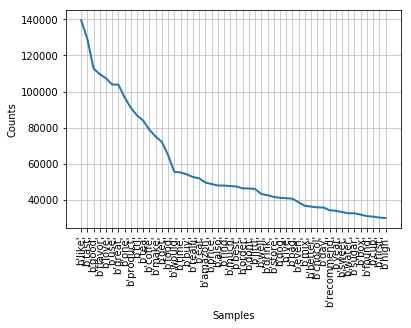

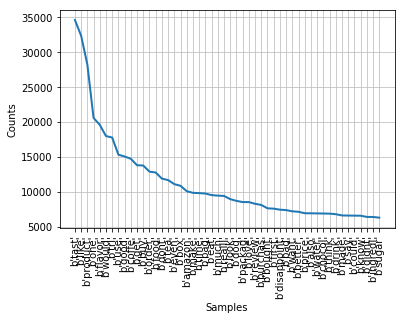

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


In [17]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
nltk.FreqDist(all_positive_words).plot(50, cumulative=False)
nltk.FreqDist(all_negative_words).plot(50, cumulative=False)

print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [18]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_10k['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 248605)
the number of unique words including both unigrams and bigrams  248605


# [7.2.5] TF-IDF

In [19]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_10k['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 248605)
the number of unique words including both unigrams and bigrams  248605


In [20]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[10000:10010])

some sample features(unique words in the corpus) ['arent food', 'arent fresh', 'arent full', 'arent given', 'arent go', 'arent good', 'arent greasi', 'arent ground', 'arent healthi', 'arent heavi']


In [21]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [22]:
top_tfidf

,feature,tfidf
0,pasta realli,0.299529
1,pasta,0.266834
2,realli enjoy,0.208757
3,daughter,0.174740
4,husband,0.162440
5,flour pasta,0.161529
6,daughter gluten,0.161529
7,sensit love,0.161529
8,delici daughter,0.161529
9,hold form,0.161529


# [7.2.6] Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_10k['CleanedText'].values:
    list_of_sent.append(sent.split())

In [28]:
print(final_10k['CleanedText'].values[2])
print("*****************************************************************")
print(list_of_sent[2])

bon produit poivr avec beaucoup goût parfum les plat san être fort recommand vivement dommag pas trouver produit franc
*****************************************************************
['bon', 'produit', 'poivr', 'avec', 'beaucoup', 'goût', 'parfum', 'les', 'plat', 'san', 'être', 'fort', 'recommand', 'vivement', 'dommag', 'pas', 'trouver', 'produit', 'franc']


In [29]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=8)

In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4713
sample words  ['great', 'tast', 'coffe', 'strong', 'weak', 'one', 'pod', 'suffici', 'morn', 'mug', 'cheaper', 'subscript', 'favorit', 'pasta', 'delici', 'daughter', 'gluten', 'sensit', 'love', 'doesnt', 'get', 'mushi', 'like', 'rice', 'realli', 'hold', 'form', 'husband', 'enjoy', 'say', 'cant', 'tell', 'differ', 'unbleach', 'flour', 'hope', 'bon', 'san', 'franc', 'bag', 'rees', 'peanut', 'butter', 'egg', 'may', 'slight', 'smaller', 'individu', 'wrap', 'still']


In [31]:
w2v_model.wv.most_similar('tasti')

[('crunchi', 0.9696117043495178),
 ('banana', 0.9627013206481934),
 ('over', 0.959102988243103),
 ('salti', 0.9491393566131592),
 ('creami', 0.9469794034957886),
 ('strawberri', 0.9440248608589172),
 ('chocolatey', 0.9414207339286804),
 ('gritti', 0.9404871463775635),
 ('delici', 0.9383053779602051),
 ('chewi', 0.9371926188468933)]

In [32]:
w2v_model.wv.most_similar('like')

[('spici', 0.8542677164077759),
 ('weird', 0.8482377529144287),
 ('aw', 0.8454083800315857),
 ('textur', 0.844629168510437),
 ('nasti', 0.8283417820930481),
 ('bland', 0.8270395994186401),
 ('salti', 0.8246541023254395),
 ('prefer', 0.8243337869644165),
 ('doesnt', 0.8231185674667358),
 ('isnt', 0.809087336063385)]

# [7.2.7] Avg W2V, TFIDF-W2V

In [33]:

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.79it/s]


10000
50


In [34]:
#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(sent_vectors)
std_data.shape

(10000, 50)

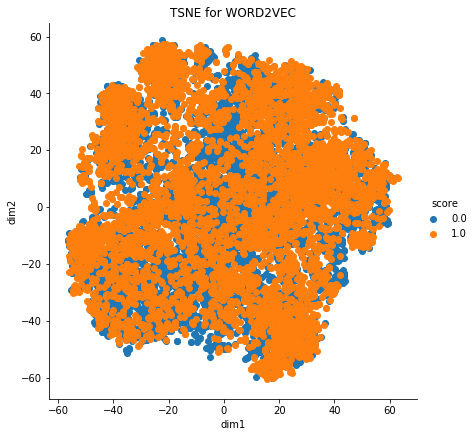

In [35]:
# tsne
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 50)
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, Score_10k)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for WORD2VEC")
plt.show()

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_10k['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [37]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 880.90it/s]


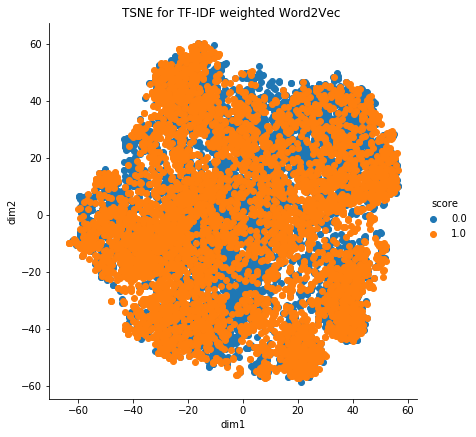

In [38]:
# tsne
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 50)
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, Score_10k)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for TF-IDF weighted Word2Vec ")
plt.show()

## observations:

By looking at all tsne representation, none of these gives well separated positive and negative reviews.